## Following online [example](https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb)

In [1]:
import re

with open('../data/Harry Potter and the Sorcerer.txt','rb') as fp:
    hp = fp.readlines()

In [2]:
corpus = []
for line in hp:
    try:
        lineDecode = line.decode('utf-8')\
            .replace('\r\n','')\
            .lower()
        corpus.append(lineDecode)
    except:
        pass
    

In [3]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [4]:
# ENGLISH_STOP_WORDS

In [5]:
corpus[:3]

["harry potter and the sorcerer's stone ", '', 'chapter one ']

In [6]:
re.findall('[a-z]+',"harry potter and the sorcerer's stone ")

['harry', 'potter', 'and', 'the', 'sorcerer', 's', 'stone']

#### tokenize, remove stop words

In [32]:
words = []

for text in corpus[:100]:
    words2append = [
        token
        for token in re.findall('\w+',text) if token not in ENGLISH_STOP_WORDS and len(token)>1
    ]
    words.extend(words2append)
words = set(words)

In [33]:
# words

#### find the neighbors

In [34]:
import pandas as pd

windowSize=2

keyValuePairs = []

for text in corpus[:20]:
    words2search = [
        token
        for token in re.findall('\w+',text) if token not in ENGLISH_STOP_WORDS and len(token)>1
    ]
    
    for idx,word in enumerate(words2search):
        for neighbor in words2search[
            max(idx-windowSize,0):
            min(idx+windowSize,len(words2search))
        ]:
            if neighbor!=word:
                keyValuePairs.append({
                    'focus':word,
                    'context':neighbor
                })
df = pd.DataFrame(keyValuePairs)           

In [35]:
df.head(3)

,context,focus
0,potter,harry
1,harry,potter
2,sorcerer,potter


In [36]:
# from collections import Counter

# words = Counter(words).most_common(100)

In [37]:
# words

#### encode words

In [38]:
wordEncode = {}
for idx,word in enumerate(words):
    wordEncode[word]=idx

In [39]:
# wordEncode

#### Define Tensorflow graph

In [40]:
import tensorflow as tf
import numpy as np

In [41]:
ONE_HOT_DIM = len(words)

In [42]:
#### one hot encoding

def oneHotEncoding(dataIndex):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[dataIndex] = 1
    return one_hot_encoding

In [43]:
x = oneHotEncoding(2)
x.shape

(599,)

In [44]:
X = [] # input word
Y = [] # target word

for x,y in zip(df.focus,df.context): ## focus-->context
    X.append(oneHotEncoding(wordEncode[x]))
    Y.append(oneHotEncoding(wordEncode[y]))

## convert to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [45]:
X_train.shape, Y_train.shape

((764, 599), (764, 599))

In [46]:
## making placeholder for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1]))
hidden_layer = tf.add(tf.matmul(x,W1),b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))

prediction = tf.nn.softmax(tf.add(
    tf.matmul(hidden_layer, W2), b2
))

# loss function: cross entropy
loss = tf.reduce_mean(
    -tf.reduce_sum(y_label * tf.log(prediction), axis=[1])
)

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

In [55]:
## train the model
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 40000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 4000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  8.479902
iteration 4000 loss is :  6.0337095
iteration 8000 loss is :  5.5012746
iteration 12000 loss is :  5.1225495
iteration 16000 loss is :  4.8246093
iteration 20000 loss is :  4.57817
iteration 24000 loss is :  4.3696723
iteration 28000 loss is :  4.20047
iteration 32000 loss is :  4.072759
iteration 36000 loss is :  3.978664


In [56]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
vectors[:10]

array([[ 1.3394772 ,  1.2385632 ],
       [ 1.591999  ,  0.75922775],
       [-1.6836376 , -0.46458086],
       [ 1.9332405 ,  0.8669335 ],
       [ 1.2539755 ,  1.8752304 ],
       [ 1.668878  ,  1.4764398 ],
       [ 2.041488  , -0.21680203],
       [ 1.7930624 , -2.5075386 ],
       [ 0.04901925,  1.3046118 ],
       [ 1.7491637 , -1.2355341 ]], dtype=float32)

In [57]:
## word vector in table
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df.head(10)

,word,x1,x2
0,time,1.339477,1.238563
1,soon,1.591999,0.759228
2,eyed,-1.683638,-0.464581
3,seconds,1.933241,0.866934
4,bright,1.253976,1.875230
5,man,1.668878,1.476440
6,dudley,2.041488,-0.216802
7,small,1.793062,-2.507539
8,clutching,0.049019,1.304612
9,rummaging,1.749164,-1.235534


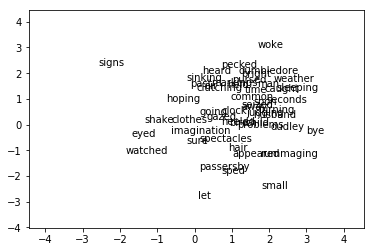

<Figure size 1440x720 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt
# %matplotlib inline

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'][:50], w2v_df['x1'][:50], w2v_df['x2'][:50]):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.figure(figsize=(20,10))

# plt.show()
plt.savefig("../data/test.pdf")


In [26]:
# plt.savefig("../data/test.svg")

<Figure size 432x288 with 0 Axes>